# Closed-Loop Cursor Control

## 1. Run the block

For this tutorial, we'll move a computer mouse to generate simulated neural data. For this to work, you'll need to update the `mouse_device` variable below so that it matches the path to your mouse on your system. 

To find the path to your mouse, check the `/dev/input/by-id/` directory for a list of device files. Usually, the file with the format "usb-NAME-event-mouse" will be your mouse. You can test this by moving your mouse around while listening for events with [`evtest`](https://manpages.ubuntu.com/manpages/trusty/man1/evtest.1.html):
```
sudo evtest /dev/input/by-id/usb-Logitech_Wireless_Receiver-event-mouse
```

In [46]:
mouse_device = '/dev/input/event8'

### Load the graph
In BRAND, each graph is configured using a YAML file. This file contains the list of nodes that will run in the graph and the parameters of each node.

In [47]:
import json
import os
import pickle
import time
from datetime import datetime

import redis
import yaml

DURATION = None  # seconds
GRAPH = 'sim_graph_cl_gen.yaml'
REDIS_IP = '127.0.0.1'
REDIS_PORT = 6379
test_dir = os.getcwd()

with open(os.path.join(test_dir, 'graphs', GRAPH), 'r') as f:
    graph = yaml.safe_load(f)

Now we'll edit the graph to use the mouse that we specified above

In [48]:
# Edit graph
node_names = [node['name'] for node in graph['nodes']]
ma_idx = node_names.index('mouseAdapter')
graph['nodes'][ma_idx]['parameters']['mouse_device'] = mouse_device

### Run the graph
In the next cell, we will send the graph parameters to BRAND's `supervisor` process, which will then run each node in the graph according to our configuration.

In [49]:
r = redis.Redis(host=REDIS_IP, port=REDIS_PORT)

curs, start_streams = r.scan(0, _type='stream')
while curs != 0:
    curs, streams = r.scan(curs, _type='stream')
    start_streams += streams

# get the most recent ID from each stream
start_id = {}
for stream in start_streams:
    replies = r.xrevrange(stream, count=1)
    if replies:
        start_id[stream] = replies[0][0]

print(f'Starting graph from {GRAPH}')
r.xadd('supervisor_ipstream', {
    'commands': 'startGraph',
    'graph': json.dumps(graph)
})

if DURATION:
    print(f'Waiting {DURATION} seconds')
    time.sleep(DURATION)
else:
    input('Hit ENTER to stop graph...')

# Stop the graph
print('Stopping graph')
r.xadd('supervisor_ipstream', {'commands': 'stopGraph'})

curs, stop_streams = r.scan(0, _type='stream')
while curs != 0:
    curs, streams = r.scan(curs, _type='stream')
    stop_streams += streams

new_streams = [
    stream for stream in stop_streams if stream not in start_streams
]

for stream in new_streams:
    start_id[stream] = 0

# Save streams
all_data = {}
for stream in stop_streams:
    all_data[stream] = r.xrange(stream, min=start_id[stream])

date_str = datetime.now().strftime(r'%y%m%dT%H%M')
graph_name = os.path.splitext(os.path.basename(GRAPH))[0]
data_dir = os.path.join(test_dir, 'data')
os.makedirs(data_dir, exist_ok=True)
save_path = os.path.join(data_dir, f'{date_str}_{graph_name}.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(all_data, f)
print(f'Saved streams: {sorted(list(all_data.keys()))}')

# Remove saved data from Redis
# delete any streams created while the graph was running
i = 0
if new_streams:
    while max([r.xlen(stream) for stream in new_streams]):
        for stream in new_streams:
            r.delete(stream)
        i += 1
r.memory_purge()
print(f'Deleted streams: {new_streams}')

Starting graph from sim_graph_cl_gen.yaml
Hit ENTER to stop graph...
Stopping graph
Saved streams: [b'bin_multiple_state', b'binned_spikes', b'booter', b'cursorData', b'display_centerOut_state', b'display_sync_pulse', b'firing_rates', b'graph_status', b'keypress', b'mouse_vel', b'radial_fsm_state', b'sim2D_state', b'state', b'supergraph_stream', b'supervisor_ipstream', b'supervisor_status', b'targetData', b'threshold_values', b'thresholds_udp_state', b'trial_info', b'trial_success', b'wiener_filter', b'wiener_filter_state']
Deleted streams: [b'radial_fsm_state', b'booter', b'trial_info', b'supervisor_ipstream', b'trial_success', b'thresholds_udp_state', b'supergraph_stream', b'cursorData', b'display_centerOut_state', b'firing_rates', b'keypress', b'wiener_filter_state', b'bin_multiple_state', b'threshold_values', b'targetData', b'state', b'display_sync_pulse', b'binned_spikes', b'wiener_filter', b'mouse_vel', b'sim2D_state']


## 2. Analyze the block
Now that we have run the graph, we will now load the data into a Pandas dataframe. The low-level details of how this is done are not critical to understand now because you may use a different process depending on your data format of choice.

In [5]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from brand.timing import timespecs_to_timestamps, timevals_to_timestamps
from scipy.signal import butter, sosfiltfilt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [6]:
# constants
test_dir = os.getcwd()
data_dir = os.path.join(test_dir, 'data')
fig_dir = os.path.join(test_dir, 'figures')
data_file = save_path

# setup
os.makedirs(fig_dir, exist_ok=True)

In [7]:
with open(os.path.join(data_dir, data_file), 'rb') as f:
    graph_data = pickle.load(f)

In [8]:
# Load graph parameters
graphs = [
    json.loads(entry[b'graph']) for _, entry in graph_data[b'booter']
    if b'graph' in entry
]
graph = graphs[-1]

In [9]:
# Load info about the structure of each stream
with open('stream_spec_cl.yaml', 'r') as f:
    stream_spec = yaml.safe_load(f)

In [10]:
# Load and parse stream data
streams = [
    b'targetData', b'cursorData', b'mouse_vel', b'binned_spikes',
    b'wiener_filter'
]
decoded_streams = {}
for stream in streams:
    print(f'Processing {stream.decode()} stream')
    stream_data = graph_data[stream]
    out = [None] * len(stream_data)
    spec = stream_spec[stream.decode()]
    for i, (entry_id, entry_data) in tqdm(enumerate(stream_data)):
        entry_dec = {}
        for key, val in entry_data.items():
            if key.decode() in spec:
                dtype = spec[key.decode()]
                if dtype == 'str':
                    entry_dec[key.decode()] = val.decode()
                elif dtype == 'sync':
                    entry_dec[key.decode()] = json.loads(val)['count']
                elif dtype == 'timeval':
                    entry_dec[key.decode()] = timevals_to_timestamps(val)
                elif dtype == 'timespec':
                    entry_dec[key.decode()] = timespecs_to_timestamps(val)
                else:
                    dat = np.frombuffer(val, dtype=dtype)
                    entry_dec[key.decode()] = dat[0] if dat.size == 1 else dat
        out[i] = entry_dec
    decoded_streams[stream.decode()] = out

Processing targetData stream


0it [00:00, ?it/s]

Processing cursorData stream


0it [00:00, ?it/s]

Processing mouse_vel stream


0it [00:00, ?it/s]

Processing binned_spikes stream


0it [00:00, ?it/s]

Processing wiener_filter stream


0it [00:00, ?it/s]

In [11]:
# Load data at the binned spikes sample rate
# FSM
cd_df = pd.DataFrame(decoded_streams['cursorData'])
cd_df.set_index('sync', drop=False, inplace=True)
cd_df.columns = [col + '_cd' for col in cd_df.columns]

td_df = pd.DataFrame(decoded_streams['targetData'])
td_df.set_index('sync', drop=False, inplace=True)
td_df['angle'] = np.degrees(np.arctan2(td_df['Y'], td_df['X']))
td_df.columns = [col + '_td' for col in td_df.columns]

# decoding
wf_df = pd.DataFrame(decoded_streams['wiener_filter'])
wf_df.set_index('sync', drop=False, inplace=True)
wf_df.columns = [col + '_wf' for col in wf_df.columns]

# binning
bs_df = pd.DataFrame(decoded_streams['binned_spikes'])
bs_df.set_index('sync', drop=False, inplace=True)
bs_df.columns = [col + '_bs' for col in bs_df.columns]

# join the dataframes
bin_df = cd_df.join(td_df).join(wf_df).join(bs_df)

### Plot cursor kinematics

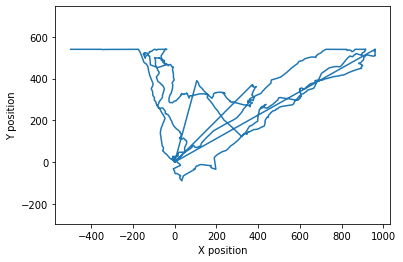

In [12]:
# plot kinematics
plt.plot(bin_df['X_cd'], bin_df['Y_cd'])
plt.axis('equal')
plt.ylabel('Y position')
plt.xlabel('X position')
plt.show()